In [43]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../../../XRaySimulation2")

from XRaySimulation import util

# Explanation
The illumination volume is contains in a region of 
20 um x 40 um x 100 um  (x, y, z)
Therefore, I can create a box with resolution of 1um along each axis
Then, I will calculate if this pixel is illuminated.
Then, I will calculate along the z axis, how many TG periods are in the illumination volume
Then, I'll calculate the mean TG period number

In [44]:
def add_weight_cylinder(start, direction, fwhm_xy, space, attenuation_length_um, surface_point, surface_normal,
                        beam_attenaution=False):
    # Get the distance
    l_pixel = (space - surface_point[np.newaxis, np.newaxis, np.newaxis, :])
    l_pixel = np.dot(l_pixel, surface_normal)
    l_pixel /= np.dot(direction, surface_normal)

    # Get a mask such that we only keep the pixel inside the surface
    sample_mask = (l_pixel >= 0)

    # Get a mask that only consider space inside the cylinder
    displacement = (space - start[np.newaxis, np.newaxis, np.newaxis, :])
    deviation = displacement - np.multiply(np.dot(displacement, direction)[:, :, :, np.newaxis],
                                           direction[np.newaxis, np.newaxis, np.newaxis, :])
    displacement_x = deviation[:, :, :, 0]
    displacement_yz = np.sqrt(deviation[:, :, :, 1] ** 2 + deviation[:, :, :, 2] ** 2)

    # Check if the pixel is within the volume of illumination
    x_ray_mask = (displacement_x ** 2 / fwhm_xy[0] ** 2 + displacement_yz ** 2 / fwhm_xy[1] ** 2 - 1 <= 0)
    total_mask = np.multiply(sample_mask, x_ray_mask)

    # Add the weight according to the attenuation coefficient
    weight = np.zeros_like(displacement_x, dtype=np.float64)
    weight[total_mask] = np.exp(-l_pixel[total_mask] / attenuation_length_um)

    if beam_attenaution:
        print("Get get the weight assuming a Gaussian X-ray profile")
        sigma_x = util.fwhm_to_sigma(fwhm=fwhm_xy[0])
        sigma_y = util.fwhm_to_sigma(fwhm=fwhm_xy[1])

        weight *= np.exp(- displacement_x ** 2 / sigma_x ** 2 / 2) / np.sqrt(np.pi * 2) / sigma_x
        weight *= np.exp(- displacement_yz ** 2 / sigma_y ** 2 / 2) / np.sqrt(np.pi * 2) / sigma_y

    else:
        print("Get get the weight assuming a flat X-ray profile")

    return weight

In [45]:
kin = np.array([-1398.73758358, -19381.33420562, 45704.44855449])
kin_direction = kin / np.linalg.norm(kin)

tilt_angle = np.deg2rad(11.5)
surface_normal = np.array([np.cos(tilt_angle), 0, -np.sin(tilt_angle)])

beam_size_x = 10.  # um
beam_size_y = 10.  # um

nx = 512
ny = 40
nz = 256

dx = 0.3 / 5 / 2
dy = 3. / 3 / 2
dz = 0.5 / 3

volume = np.zeros((nx, ny, nz, 3))
volume[:, :, :, 0] = np.linspace(-nx * dx / 2, nx * dx / 2, num=nx)[:, np.newaxis, np.newaxis]
volume[:, :, :, 1] = np.linspace(-ny * dy / 2, ny * dy / 2, num=ny)[np.newaxis, :, np.newaxis]
volume[:, :, :, 2] = np.linspace(-nx * dz / 2, nx * dz / 2, num=nz)[np.newaxis, np.newaxis, :]

In [46]:
# Get the total weight
weight_pulse1 = add_weight_cylinder(start=np.zeros(3),
                                    direction=np.array([np.sin(np.deg2rad(0.2)), 0, np.cos(np.deg2rad(0.2))]),
                                    fwhm_xy=[10, 10],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.zeros(3),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse2 = add_weight_cylinder(start=np.zeros(3),
                                    direction=np.array([-np.sin(np.deg2rad(0.2)), 0, np.cos(np.deg2rad(0.2))]),
                                    fwhm_xy=[10, 10],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.zeros(3),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse3 = add_weight_cylinder(start=np.zeros(3),
                                    direction=kin_direction,
                                    fwhm_xy=[10, 10],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.zeros(3),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
pump_weight = weight_pulse1 + weight_pulse2
probe_weight = weight_pulse3

total_weight = probe_weight + pump_weight

Get get the weight assuming a Gaussian X-ray profile
Get get the weight assuming a Gaussian X-ray profile
Get get the weight assuming a Gaussian X-ray profile


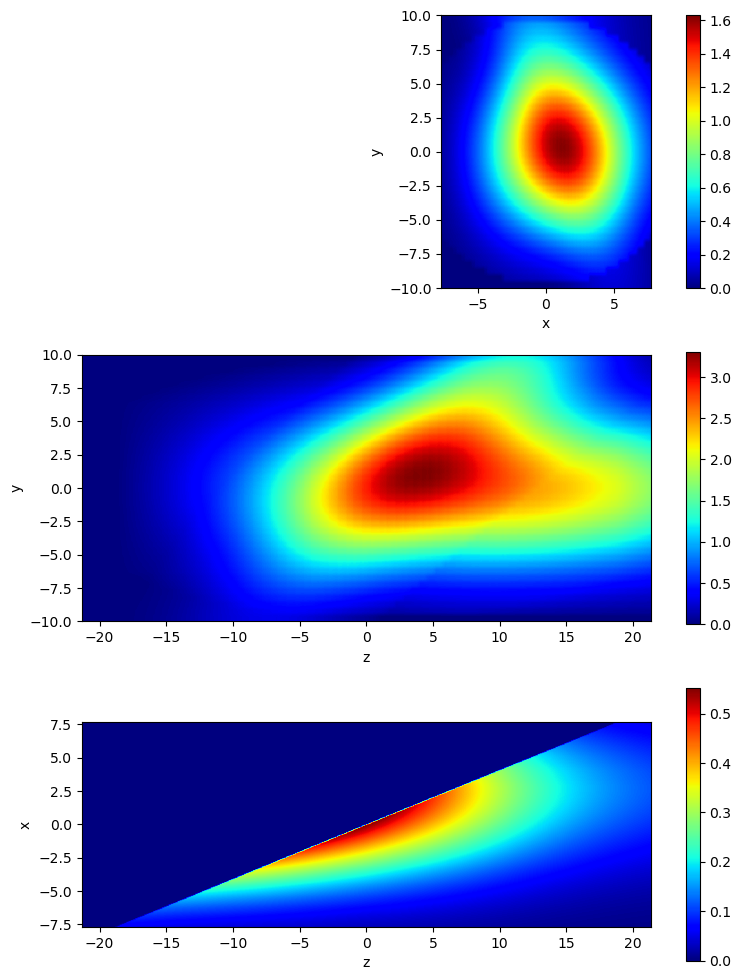

In [47]:
weight_xy = np.sum(total_weight, axis=-1)
weight_xz = np.sum(total_weight, axis=1)
weight_yz = np.sum(total_weight, axis=0)

fig, axes = plt.subplots(ncols=1, nrows=3)
fig.set_figheight(10)
fig.set_figwidth(8)
im1 = axes[0].imshow(weight_xy.T[:, ::-1], extent=[-nx * dx / 2, nx * dx / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
fig.colorbar(im1, ax=axes[0])
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

im2 = axes[1].imshow(weight_yz, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
fig.colorbar(im2, ax=axes[1])
axes[1].set_xlabel("z")
axes[1].set_ylabel("y")

im3 = axes[2].imshow(weight_xz[::-1, ], extent=[-nz * dz / 2, nz * dz / 2, -nx * dx / 2, nx * dx / 2], cmap='jet')
fig.colorbar(im3, ax=axes[2])
axes[2].set_xlabel("z")
axes[2].set_ylabel("x")

plt.tight_layout()
plt.show()

In [48]:
# Get the scattering volume
scatter_volume = np.multiply(np.multiply(weight_pulse1, weight_pulse2), weight_pulse3)

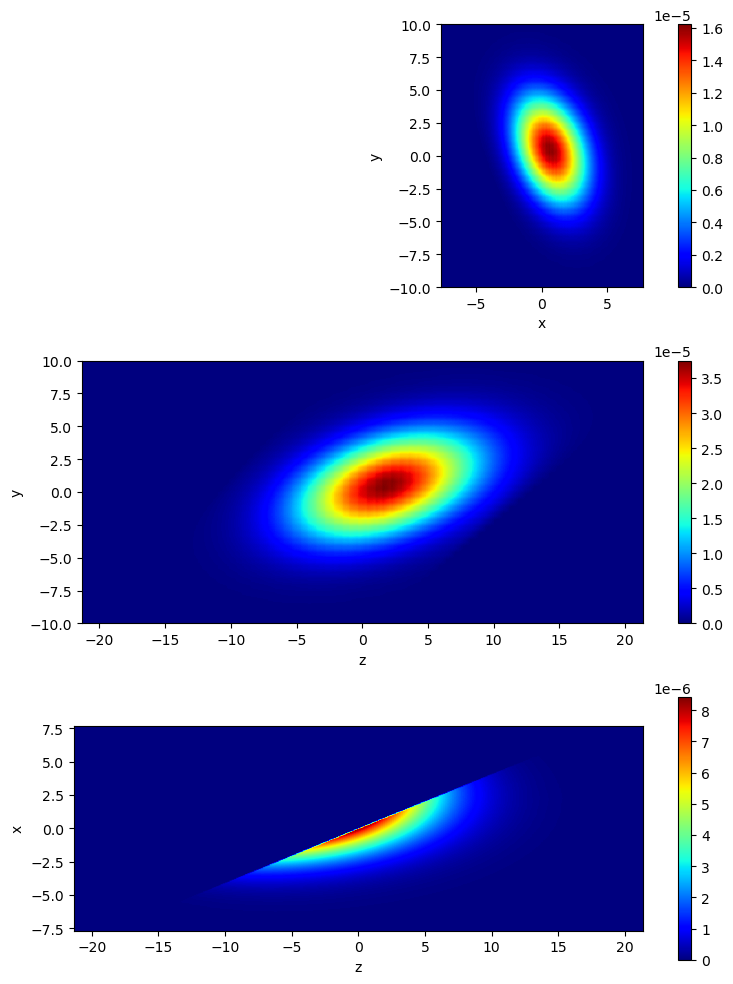

In [49]:
weight_xy = np.sum(scatter_volume, axis=-1)
weight_xz = np.sum(scatter_volume, axis=1)
weight_yz = np.sum(scatter_volume, axis=0)

fig, axes = plt.subplots(ncols=1, nrows=3)
fig.set_figheight(10)
fig.set_figwidth(8)
im1 = axes[0].imshow(weight_xy.T[:, ::-1], extent=[-nx * dx / 2, nx * dx / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
fig.colorbar(im1, ax=axes[0])
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

im2 = axes[1].imshow(weight_yz, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
fig.colorbar(im2, ax=axes[1])
axes[1].set_xlabel("z")
axes[1].set_ylabel("y")

im3 = axes[2].imshow(weight_xz[::-1, ], extent=[-nz * dz / 2, nz * dz / 2, -nx * dx / 2, nx * dx / 2], cmap='jet')
fig.colorbar(im3, ax=axes[2])
axes[2].set_xlabel("z")
axes[2].set_ylabel("x")

plt.tight_layout()
plt.show()

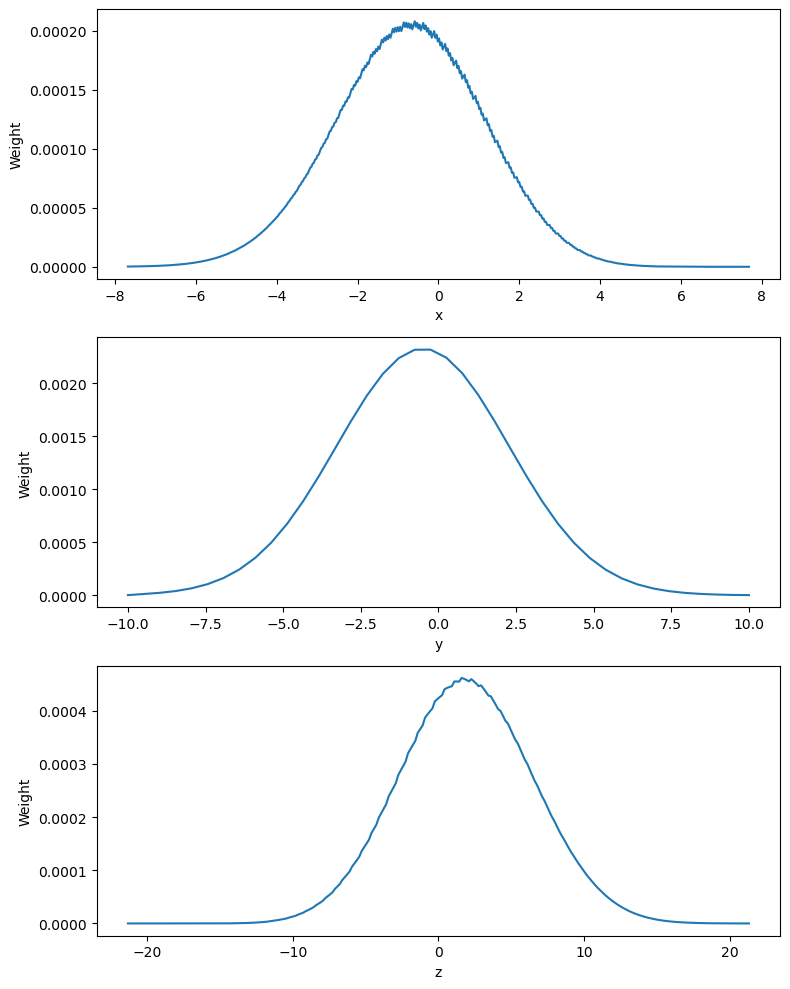

In [50]:
# Get the 1d projection
weight_x = np.sum(scatter_volume, axis=(1, 2))
weight_y = np.sum(scatter_volume, axis=(0, 2))
weight_z = np.sum(scatter_volume, axis=(0, 1))

fig, axes = plt.subplots(ncols=1, nrows=3)
fig.set_figheight(10)
fig.set_figwidth(8)
im1 = axes[0].plot(np.linspace(-nx * dx / 2, nx * dx / 2, nx), weight_x)
axes[0].set_xlabel("x")
axes[0].set_ylabel("Weight")

im2 = axes[1].plot(np.linspace(-ny * dy / 2, ny * dy / 2, ny), weight_y)
axes[1].set_xlabel("y")
axes[1].set_ylabel("Weight")

im3 = axes[2].plot(np.linspace(-nz * dz / 2, nz * dz / 2, nz), weight_z)
axes[2].set_xlabel("z")
axes[2].set_ylabel("Weight")

plt.tight_layout()
plt.show()

# Further analysis 

In [90]:
# Get the length along the x direction
probability = scatter_volume  #/ (np.sum(scatter_volume, axis=0) + 1e-10)[np.newaxis, :, :]

# Get the FWHM along each x direction
half_max = (np.max(probability, axis=0) + np.min(probability, axis=0)) / 2.

# Get the indexes for the range.
indexes = np.arange(nx, dtype=np.int64)[:, np.newaxis, np.newaxis] * np.ones((ny, nz), dtype=np.int64)
mask = np.zeros_like(indexes, dtype=bool)
mask[probability >= half_max[np.newaxis, :, :]] = True

# Convert the indexes into coordinates
grating_size = (np.count_nonzero(mask, axis=0)).astype(np.float64) * dx
grating_num = grating_size / 11.8e-3

# Add some mask
illumination_volume_mask = np.sum(scatter_volume, axis=0) < 1e-8
grating_num[illumination_volume_mask] = 0

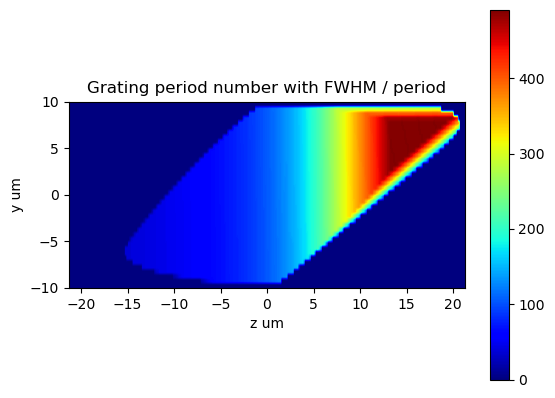

In [91]:
plt.imshow(grating_num, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
plt.xlabel('z um')
plt.ylabel('y um')
plt.title("Grating period number with FWHM / period")
plt.colorbar()
plt.show()

In [92]:
# Get the weighted sum
pixel_weight = np.sum(scatter_volume, axis=0)
grating_num_mean = np.sum(np.multiply(pixel_weight, grating_num)) / np.sum(pixel_weight)
print("The pixel weighted grating period numbe|r is {:.2f}.".format(grating_num_mean))

The pixel weighted grating period numbe|r is 157.94.


# Add the coherent length effect

In [93]:
kout = np.array([30782.07465862, 12799.47803659, 45704.44855449])
kout_dir = kout / np.linalg.norm(kout)

In [99]:
proj = grating_size * np.dot(kout_dir, np.array([1., 0, 0,])) / util.c
proj[illumination_volume_mask] = 0

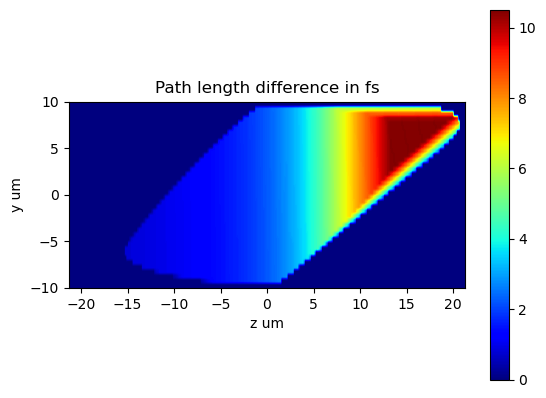

In [102]:
plt.imshow(proj, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
plt.xlabel('z um')
plt.ylabel('y um')
plt.title("Path length difference in fs")
plt.colorbar()
plt.show()